**Entendimiento de los datos**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Primeras filas del dataset:
   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 

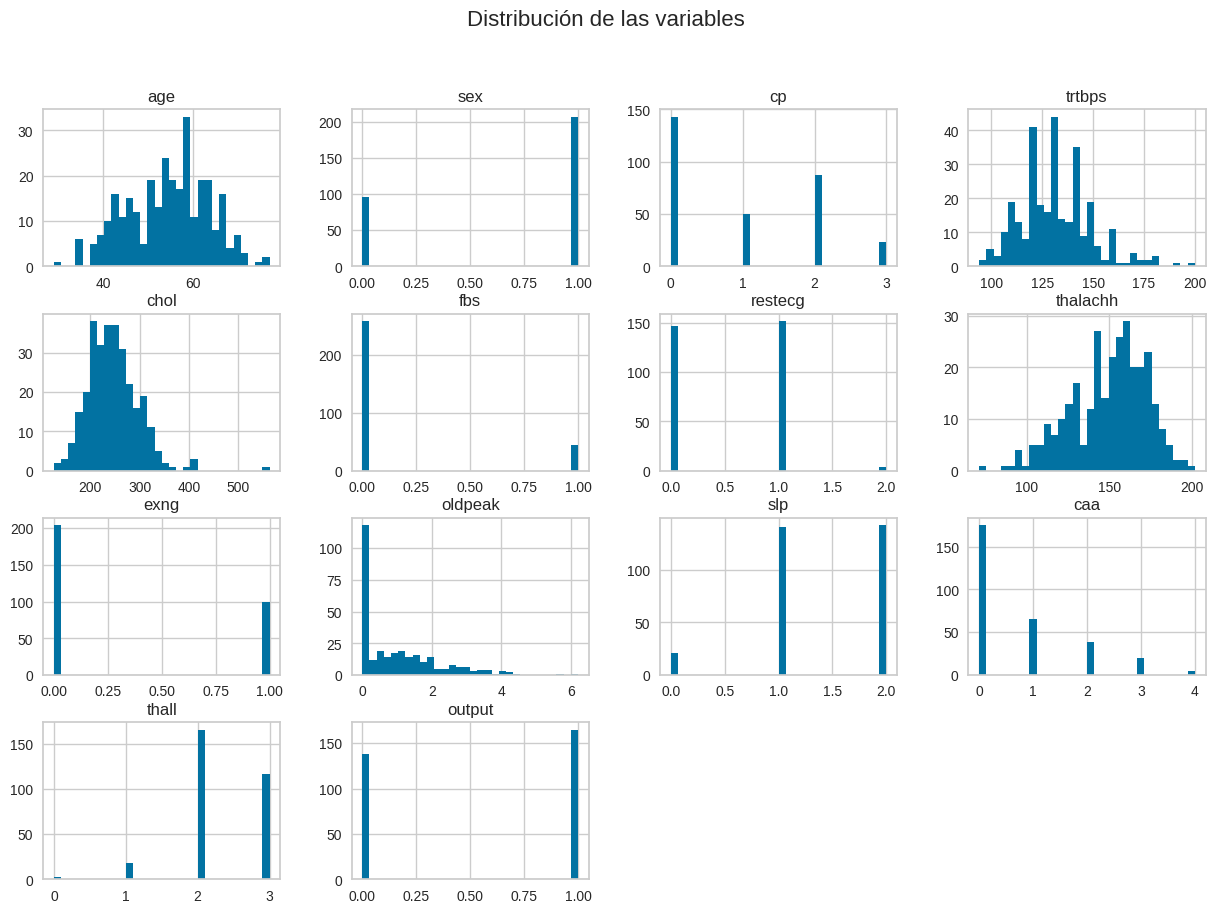

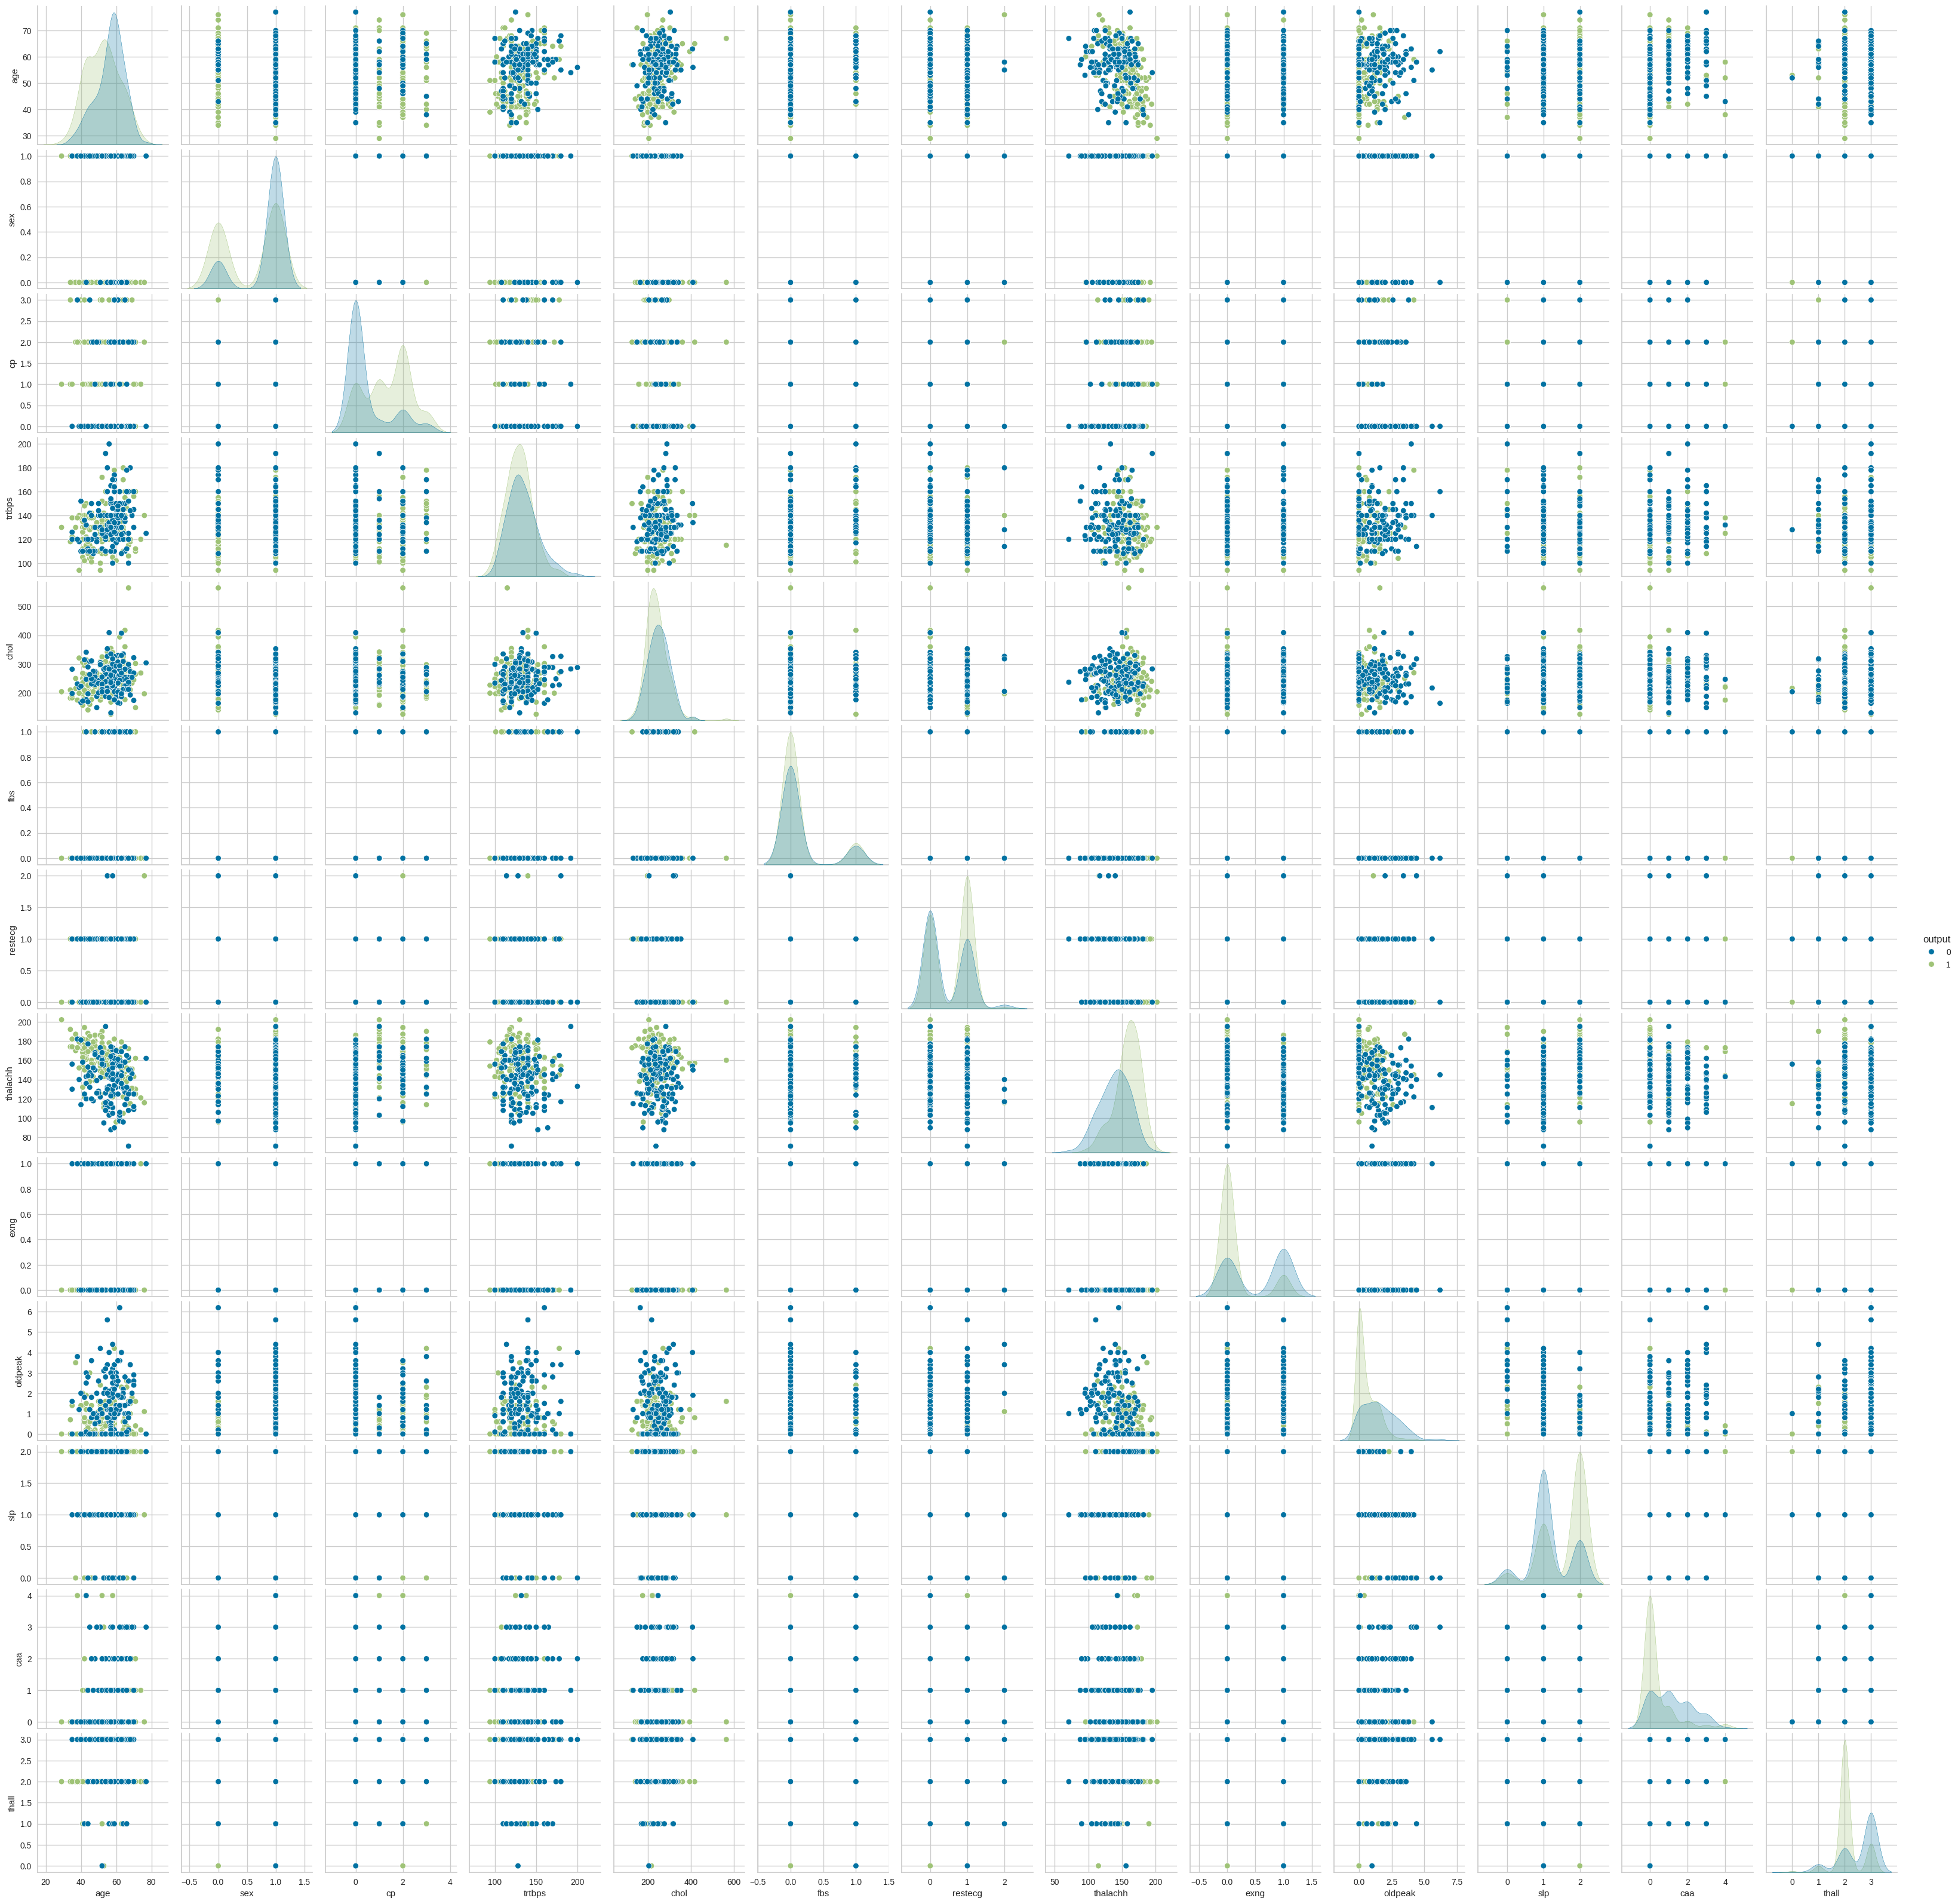

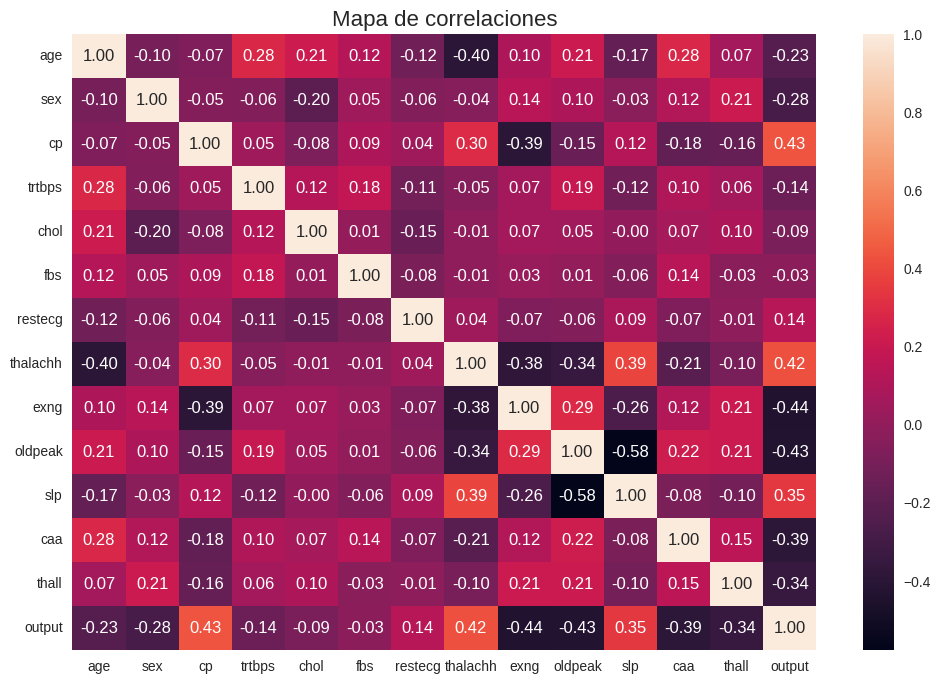

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo
file_path = "/content/drive/My Drive/heart.csv"  # Cambia esta ruta si es necesario

# Cargar el dataset
df = pd.read_csv(file_path)

# Vista inicial de los datos
print("Primeras filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
print(df.info())
print("\nDescripción estadística del dataset:")
print(df.describe())

# Visualización univariante
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribución de las variables", fontsize=16)
plt.show()

# Visualización bivariante
sns.pairplot(df, hue='output')  # Cambiado a 'output'
plt.show()

# Correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Mapa de correlaciones", fontsize=16)
plt.show()


**Preparación de datos**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separar variables de entrada y salida
X = df.drop("output", axis=1)
y = df["output"]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[["age", "trtbps", "chol", "thalachh", "oldpeak"]])

# Codificación de variables categóricas
X = pd.get_dummies(X, columns=["cp", "thall", "caa"], drop_first=True)

# Balanceo de clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


**Modelacion sin PyCaret**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Modelos base
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
}

# Entrenar y evaluar modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.86
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.86      0.88      0.87        34

    accuracy                           0.86        66
   macro avg       0.86      0.86      0.86        66
weighted avg       0.86      0.86      0.86        66


Decision Tree Accuracy: 0.74
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.70      0.88      0.78        34

    accuracy                           0.74        66
   macro avg       0.76      0.74      0.74        66
weighted avg       0.76      0.74      0.74        66


Random Forest Accuracy: 0.82
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
         

**Busqueda de hiperparametros**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Ejemplo para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print("\nMejores hiperparámetros para Random Forest:")
print(grid_search.best_params_)



Mejores hiperparámetros para Random Forest:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


**Modelacion con PyCaret**

In [24]:
!pip install pycaret
from pycaret.classification import *

# Combinar X e y en un DataFrame
data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="output")], axis=1)

# Configuración inicial
clf_setup = setup(data=data, target="output",
                  train_size=0.8,  # 80% para entrenamiento
                  normalize=True,  # Normalizar datos
                  session_id=42,  # Reproducibilidad
                  fold=5)  # Validación cruzada
from pycaret.classification import *

# Combinar X e y en un DataFrame
data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="output")], axis=1)

# Configuración inicial
clf_setup = setup(data=data, target="output",
                  train_size=0.8,  # 80% para entrenamiento
                  normalize=True,  # Normalizar datos
                  session_id=42,  # Reproducibilidad
                  fold=5)  # Validación cruzada
# Comparar modelos
best_model = compare_models()
# Evaluar el mejor modelo
evaluate_model(best_model)


,Description,Value
0,Session id,42
1,Target,output
2,Target type,Binary
3,Original data shape,"(330, 21)"
4,Transformed data shape,"(330, 21)"
5,Transformed train set shape,"(264, 21)"
6,Transformed test set shape,"(66, 21)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,42
1,Target,output
2,Target type,Binary
3,Original data shape,"(330, 21)"
4,Transformed data shape,"(330, 21)"
5,Transformed train set shape,"(264, 21)"
6,Transformed test set shape,"(66, 21)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8449,0.9228,0.8641,0.8345,0.8467,0.6897,0.6943,1.8560
ridge,Ridge Classifier,0.8449,0.9213,0.8792,0.8250,0.8496,0.6898,0.6946,0.1040
lda,Linear Discriminant Analysis,0.8449,0.9207,0.8792,0.8250,0.8496,0.6898,0.6946,0.1800
et,Extra Trees Classifier,0.8336,0.9099,0.8179,0.8529,0.8276,0.6668,0.6760,0.3660
svm,SVM - Linear Kernel,0.8261,0.9029,0.8410,0.8165,0.8271,0.6518,0.6548,0.1020
nb,Naive Bayes,0.8223,0.8759,0.8422,0.8108,0.8233,0.6447,0.6506,0.1280
rf,Random Forest Classifier,0.8221,0.8927,0.8108,0.8353,0.8175,0.6440,0.6516,0.5060
ada,Ada Boost Classifier,0.8183,0.8920,0.8330,0.8113,0.8205,0.6365,0.6393,0.2240
xgboost,Extreme Gradient Boosting,0.7954,0.8837,0.7883,0.8078,0.7930,0.5912,0.5987,0.1080
gbc,Gradient Boosting Classifier,0.7840,0.8871,0.7798,0.7887,0.7824,0.5675,0.5701,0.5520


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
# Optimizar los 5 modelos seleccionados
tuned_models = [tune_model(model) for model in top_models]


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8491,0.9330,0.7692,0.9091,0.8333,0.6971,0.7053
1,0.8679,0.9330,0.9615,0.8065,0.8772,0.7367,0.7501
2,0.8302,0.9031,0.8889,0.8000,0.8421,0.6595,0.6638
3,0.7925,0.8818,0.7778,0.8077,0.7925,0.5851,0.5855
4,0.9038,0.9586,0.9231,0.8889,0.9057,0.8077,0.8083
Mean,0.8487,0.9219,0.8641,0.8424,0.8501,0.6972,0.7026
Std,0.0372,0.0267,0.0775,0.0467,0.0387,0.0745,0.0757


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8491,0.9316,0.8077,0.8750,0.8400,0.6976,0.6996
1,0.8491,0.9259,0.9615,0.7812,0.8621,0.6993,0.7178
2,0.8302,0.9060,0.8889,0.8000,0.8421,0.6595,0.6638
3,0.7925,0.8960,0.8148,0.7857,0.8000,0.5845,0.5849
4,0.9038,0.9467,0.9231,0.8889,0.9057,0.8077,0.8083
Mean,0.8449,0.9213,0.8792,0.8262,0.8500,0.6897,0.6949
Std,0.0360,0.0182,0.0601,0.0462,0.0344,0.0722,0.0728


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8302,0.9330,0.8077,0.8400,0.8235,0.6600,0.6605
1,0.8491,0.9202,0.9231,0.8000,0.8571,0.6989,0.7069
2,0.8302,0.9074,0.8519,0.8214,0.8364,0.6600,0.6605
3,0.8302,0.8960,0.8519,0.8214,0.8364,0.6600,0.6605
4,0.9231,0.9497,0.9615,0.8929,0.9259,0.8462,0.8487
Mean,0.8525,0.9213,0.8792,0.8351,0.8559,0.7050,0.7074
Std,0.0360,0.0189,0.0553,0.0315,0.0367,0.0722,0.0729


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8113,0.8860,0.7692,0.8333,0.8000,0.6220,0.6238
1,0.8491,0.8547,0.9615,0.7812,0.8621,0.6993,0.7178
2,0.7925,0.8590,0.8148,0.7857,0.8000,0.5845,0.5849
3,0.7547,0.8362,0.7037,0.7917,0.7451,0.5103,0.5136
4,0.9038,0.9438,0.9615,0.8621,0.9091,0.8077,0.8131
Mean,0.8223,0.8759,0.8422,0.8108,0.8233,0.6447,0.6506
Std,0.0509,0.0375,0.1037,0.0316,0.0567,0.1017,0.1046


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7736,0.8989,0.7692,0.7692,0.7692,0.5470,0.5470
1,0.8679,0.9046,0.9615,0.8065,0.8772,0.7367,0.7501
2,0.8113,0.8775,0.7778,0.8400,0.8077,0.6230,0.6248
3,0.8491,0.8889,0.8889,0.8276,0.8571,0.6976,0.6996
4,0.9038,0.9423,0.9615,0.8621,0.9091,0.8077,0.8131
Mean,0.8411,0.9024,0.8718,0.8211,0.8441,0.6824,0.6869
Std,0.0451,0.0220,0.0846,0.0316,0.0498,0.0903,0.0933


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
# Evaluar cada modelo optimizado
for tuned_model in tuned_models:
    evaluate_model(tuned_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [27]:
# Entrenar el modelo final con todos los datos
final_model = finalize_model(tuned_models[0])  # Selecciona el mejor modelo optimizado


In [28]:
from pycaret.classification import save_model

# Guardar el modelo
save_model(final_model, "modelo_logistic_regression")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'sex', 'trtbps', 'chol',
                                              'fbs', 'restecg', 'thalachh',
                                              'exng', 'oldpeak', 'slp'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  Trans...
                  TransformerWrapper(exclude=None, include=None,
                

In [30]:
from pycaret.classification import save_model

# Guardar el pipeline y el modelo
save_model(final_model, "mejor_modelo_pipeline")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'sex', 'trtbps', 'chol',
                                              'fbs', 'restecg', 'thalachh',
                                              'exng', 'oldpeak', 'slp'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  Trans...
                  TransformerWrapper(exclude=None, include=None,
                

**FAST API**

In [31]:
from fastapi import FastAPI
import pandas as pd
from pycaret.classification import load_model, predict_model

# Cargar el modelo guardado
model = load_model("mejor_modelo_pipeline")

# Inicializar la aplicación FastAPI
app = FastAPI()

@app.post("/predict/")
def predict(data: dict):
    """
    Endpoint para predecir la salida de un modelo entrenado.
    """
    # Convertir los datos de entrada en un DataFrame
    input_data = pd.DataFrame([data])

    # Realizar la predicción
    prediction = predict_model(model, data=input_data)

    # Retornar la predicción
    return {
        "prediction_label": prediction["Label"][0],
        "prediction_score": prediction["Score"][0],
    }


Transformation Pipeline and Model Successfully Loaded
